# Import statements

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
import datetime
import json
import statsmodels.api as sm

# Read in NYSE tickers, get 1000 largest companies, remove those with IPO after 12/31/2009 and those that yfinance has no data for, keep data starting from day at which all companies are publicly traded, and save data 

In [7]:
df = pd.read_csv('data/nyse_tickers.csv')
df.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$126.97,-1.0900,-0.851%,3.754526e+10,United States,1999.0,733982,Industrials,Electrical Products
1,AA,Alcoa Corporation Common Stock,$35.28,-0.8600,-2.38%,6.292347e+09,NaN,2016.0,2083531,Industrials,Aluminum
2,AAC,Ares Acquisition Corporation Class A Ordinary ...,$10.43,0.0000,0.00%,0.000000e+00,NaN,2021.0,9816,Industrials,Metal Fabrications
3,AAIC,Arlington Asset Investment Corp Class A (new),$2.59,-0.0200,-0.766%,7.345356e+07,United States,NaN,3472,Real Estate,Real Estate Investment Trusts
4,AAIC^B,Arlington Asset Investment Corp 7.00%,$17.48,-0.0021,-0.012%,NaN,United States,NaN,100,NaN,NaN


In [8]:
df.dtypes

Symbol         object
Name           object
Last Sale      object
Net Change    float64
% Change       object
Market Cap    float64
Country        object
IPO Year      float64
Volume          int64
Sector         object
Industry       object
dtype: object

In [9]:
df.sort_values(by=['Market Cap'],ascending=False,inplace=True)
df.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
450,BRK/A,Berkshire Hathaway Inc.,$490688.50,-1311.500,-0.267%,7.217410e+11,United States,NaN,4678,NaN,NaN
451,BRK/B,Berkshire Hathaway Inc.,$321.56,-1.430,-0.443%,7.094615e+11,United States,NaN,1132868,NaN,NaN
1474,JNJ,Johnson & Johnson Common Stock,$159.93,-1.720,-1.064%,4.989564e+11,United States,NaN,2526818,Health Care,Biotechnology: Pharmaceutical Preparations
2755,V,Visa Inc.,$230.67,-0.600,-0.259%,4.848190e+11,United States,NaN,1732859,Consumer Discretionary,Business Services
2721,UNH,UnitedHealth Group Incorporated Common Stock (DE),$486.815,-3.255,-0.664%,4.535181e+11,United States,NaN,1228681,Health Care,Medical Specialities


In [10]:
symbols = df.iloc[:1000,:]['Symbol'] #1000 symbols corresponding to largest companies on nyse

In [11]:
new = []
symbols = list(symbols)
for s in symbols:
    new.append(s.replace('^','-').replace('/','-').replace('.','-'))
symbols = new[:]

In [12]:
yf.Ticker('brk-b').history(period='max').head(1).index[0]

Timestamp('1996-05-09 00:00:00-0400', tz='America/New_York')

In [13]:
remove = []
for s in symbols:
    hist_df = yf.Ticker(s.upper()).history(period='max')
    if hist_df.shape[0] == 0:
        remove.append(s)
        continue
    year = hist_df.head(1).index[0].year
    if year >= 2010:
        remove.append(s)

In [14]:
symbols = set(symbols).difference(set(remove))

In [15]:
sym_str = ''
for s in symbols:
    sym_str+=s+' '
data = yf.download(sym_str,period='max')

[*********************100%***********************]  719 of 719 completed


In [16]:
for i in range(data.shape[0]):
    day = data.iloc[i,:]
    if True not in list(day.isna()):
        pts = day.name
        print(pts)
        break

2009-12-29 00:00:00


In [17]:
data = data.loc[pts:,:]

In [18]:
months = []
days = []
years = []
index = data.index
for date in index:
    months.append(date.month)
    days.append(date.day)
    years.append(date.year)
months = pd.Series(months,index=index)
years = pd.Series(years,index=index)
days = pd.Series(days,index=index)
data['Month'] = months
data['Day'] = days
data['Year'] = years
data.head()

Adj Close                                                        \
                    A         AA        AAP        AB        ABB        ABC   
Date                                                                          
2009-12-29  19.640221  35.237850  37.049263  9.560408  12.084814  21.653866   
2009-12-30  20.138828  35.831375  37.276485  9.712654  12.072253  21.604593   
2009-12-31  20.119404  35.435684  36.794739  9.723031  11.996881  21.407518   
2010-01-04  20.268343  36.600750  36.703854  9.826839  12.336060  21.867371   
2010-01-05  20.048174  35.457676  36.485683  9.816462  12.417715  21.711342   

                                                   ...     Volume              \
                ABEV    ABG        ABT        ACM  ...         WY           X   
Date                                               ...                          
2009-12-29  2.183233  11.78  19.265387  27.797506  ...   760100.0   8529900.0   
2009-12-30  2.174173  11.81  19.364799  27.402517  ...   647100.0   8010200.0   
2009-12-31  2.172915  11.53  19.169523  27.155645  ...   702000.0   3589500.0   
2010-01-04  2.264763  11.83  19.336399  27.797506  ...  1832400.0  10339400.0   
2010-01-05  2.249161  12.39  19.180187  28.103622  ...  1724500.0   9003200.0   

                                                             Month Day  Year  
                 XOM      XPO      YPF        YUM        ZBH                  
Date                                                                          
2009-12-29  19985700  69683.0   3600.0  2844734.0   607906.0    12  29  2009  
2009-12-30  19860600  18722.0   2600.0  1886196.0   594413.0    12  30  2009  
2009-12-31  18852300  36648.0  11300.0  1790217.0   579169.0    12  31  2009  
2010-01-04  27809100  28336.0   5100.0  2962274.0   805872.0     1   4  2010  
2010-01-05  30174700  44744.0   5300.0  3298757.0  1769643.0     1   5  2010  

[5 rows x 4317 columns]

In [19]:
data['Date']=pd.Series(data.index,index=data.index)

In [20]:
data.reset_index(drop=True,inplace=True)

In [21]:
data.columns

MultiIndex([('Adj Close',    'A'),
            ('Adj Close',   'AA'),
            ('Adj Close',  'AAP'),
            ('Adj Close',   'AB'),
            ('Adj Close',  'ABB'),
            ('Adj Close',  'ABC'),
            ('Adj Close', 'ABEV'),
            ('Adj Close',  'ABG'),
            ('Adj Close',  'ABT'),
            ('Adj Close',  'ACM'),
            ...
            (   'Volume',    'X'),
            (   'Volume',  'XOM'),
            (   'Volume',  'XPO'),
            (   'Volume',  'YPF'),
            (   'Volume',  'YUM'),
            (   'Volume',  'ZBH'),
            (    'Month',     ''),
            (      'Day',     ''),
            (     'Year',     ''),
            (     'Date',     '')],
           length=4318)

In [22]:
new_cols = []
cur_cols = list(data.columns)
for tup in cur_cols:
    if tup[1] == '':
        new_cols.append(tup[0])
    else:
        new_cols.append(tup[0]+': ' + tup[1])
data.columns = new_cols
data.head()

,Adj Close: A,Adj Close: AA,Adj Close: AAP,Adj Close: AB,Adj Close: ABB,Adj Close: ABC,Adj Close: ABEV,Adj Close: ABG,Adj Close: ABT,Adj Close: ACM,...,Volume: X,Volume: XOM,Volume: XPO,Volume: YPF,Volume: YUM,Volume: ZBH,Month,Day,Year,Date
0,19.640221,35.237850,37.049263,9.560408,12.084814,21.653866,2.183233,11.78,19.265387,27.797506,...,8529900.0,19985700,69683.0,3600.0,2844734.0,607906.0,12,29,2009,2009-12-29
1,20.138828,35.831375,37.276485,9.712654,12.072253,21.604593,2.174173,11.81,19.364799,27.402517,...,8010200.0,19860600,18722.0,2600.0,1886196.0,594413.0,12,30,2009,2009-12-30
2,20.119404,35.435684,36.794739,9.723031,11.996881,21.407518,2.172915,11.53,19.169523,27.155645,...,3589500.0,18852300,36648.0,11300.0,1790217.0,579169.0,12,31,2009,2009-12-31
3,20.268343,36.600750,36.703854,9.826839,12.336060,21.867371,2.264763,11.83,19.336399,27.797506,...,10339400.0,27809100,28336.0,5100.0,2962274.0,805872.0,1,4,2010,2010-01-04
4,20.048174,35.457676,36.485683,9.816462,12.417715,21.711342,2.249161,12.39,19.180187,28.103622,...,9003200.0,30174700,44744.0,5300.0,3298757.0,1769643.0,1,5,2010,2010-01-05


In [23]:
data.to_csv('assets_data.csv',index=False)

# End

# Read in assets' data

In [24]:
assets_data = pd.read_csv('data/assets_data.csv')
assets_data.head()

,Adj Close: A,Adj Close: AA,Adj Close: AAP,Adj Close: AB,Adj Close: ABB,Adj Close: ABC,Adj Close: ABEV,Adj Close: ABG,Adj Close: ABT,Adj Close: ACM,...,Volume: X,Volume: XOM,Volume: XPO,Volume: YPF,Volume: YUM,Volume: ZBH,Month,Day,Year,Date
0,19.640221,35.237850,37.049263,9.560408,12.084814,21.653866,2.183233,11.78,19.265387,27.797506,...,8529900.0,19985700,69683.0,3600.0,2844734.0,607906.0,12,29,2009,2009-12-29
1,20.138828,35.831375,37.276485,9.712654,12.072253,21.604593,2.174173,11.81,19.364799,27.402517,...,8010200.0,19860600,18722.0,2600.0,1886196.0,594413.0,12,30,2009,2009-12-30
2,20.119404,35.435684,36.794739,9.723031,11.996881,21.407518,2.172915,11.53,19.169523,27.155645,...,3589500.0,18852300,36648.0,11300.0,1790217.0,579169.0,12,31,2009,2009-12-31
3,20.268343,36.600750,36.703854,9.826839,12.336060,21.867371,2.264763,11.83,19.336399,27.797506,...,10339400.0,27809100,28336.0,5100.0,2962274.0,805872.0,1,4,2010,2010-01-04
4,20.048174,35.457676,36.485683,9.816462,12.417715,21.711342,2.249161,12.39,19.180187,28.103622,...,9003200.0,30174700,44744.0,5300.0,3298757.0,1769643.0,1,5,2010,2010-01-05


# End

# Get market data and save it

In [25]:
market_df = yf.Ticker('SPY').history(period='max')
market_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
1993-01-29 00:00:00-05:00,25.140224,25.140224,25.015149,25.122356,1003200,0.0,0.0,0.0
1993-02-01 00:00:00-05:00,25.140219,25.301031,25.140219,25.301031,480500,0.0,0.0,0.0
1993-02-02 00:00:00-05:00,25.283154,25.372494,25.229550,25.354626,201300,0.0,0.0,0.0
1993-02-03 00:00:00-05:00,25.390365,25.640516,25.372497,25.622648,529400,0.0,0.0,0.0
1993-02-04 00:00:00-05:00,25.711990,25.783462,25.426103,25.729858,531500,0.0,0.0,0.0


In [26]:
months = []
days = []
years = []
index = market_df.index
new_index = []
for ts in index:
    new_index.append(ts.date())
for date in index:
    months.append(date.month)
    days.append(date.day)
    years.append(date.year)
months = pd.Series(months,index=index)
years = pd.Series(years,index=index)
days = pd.Series(days,index=index)
dates = pd.Series(new_index,index=index)
market_df['Month'] = months
market_df['Day'] = days
market_df['Year'] = years
market_df['Date'] = dates
market_df.reset_index(drop=True,inplace=True)

market_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Month,Day,Year,Date
0,25.140224,25.140224,25.015149,25.122356,1003200,0.0,0.0,0.0,1,29,1993,1993-01-29
1,25.140219,25.301031,25.140219,25.301031,480500,0.0,0.0,0.0,2,1,1993,1993-02-01
2,25.283154,25.372494,25.229550,25.354626,201300,0.0,0.0,0.0,2,2,1993,1993-02-02
3,25.390365,25.640516,25.372497,25.622648,529400,0.0,0.0,0.0,2,3,1993,1993-02-03
4,25.711990,25.783462,25.426103,25.729858,531500,0.0,0.0,0.0,2,4,1993,1993-02-04


In [27]:
market_df.to_csv('market_data.csv',index=False)

# End

# Read in market data

In [28]:
market_df = pd.read_csv('data/market_data.csv')
market_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Month,Day,Year,Date
0,25.140224,25.140224,25.015149,25.122356,1003200,0.0,0.0,0.0,1,29,1993,1993-01-29
1,25.140219,25.301031,25.140219,25.301031,480500,0.0,0.0,0.0,2,1,1993,1993-02-01
2,25.283154,25.372494,25.229550,25.354626,201300,0.0,0.0,0.0,2,2,1993,1993-02-02
3,25.390365,25.640516,25.372497,25.622648,529400,0.0,0.0,0.0,2,3,1993,1993-02-03
4,25.711990,25.783462,25.426103,25.729858,531500,0.0,0.0,0.0,2,4,1993,1993-02-04


# End

# Create monthly returns json and save it

In [29]:
monthly_asset_gb = assets_data.groupby(['Year','Month'])

In [30]:
monthly_market_gb = market_df.groupby(['Year','Month'])

In [31]:
monthly_rets = {}

for yr in range(2010,2024):
    monthly_rets[yr] = {}
    if yr < 2023:
        end_month = 13
    else:
        end_month = 5
    for month in range(1,end_month):
        group_indexer = (yr,month)
        monthly_rets[yr][month] = {}
        asset_gb = monthly_asset_gb.get_group(group_indexer)
        market_gb = monthly_market_gb.get_group(group_indexer)
        
        market_first_day = market_gb.head(1)
        market_last_day = market_gb.tail(1)
        market_month_open = market_first_day['Open'].iloc[0]
        market_month_close = market_last_day['Close'].iloc[0]
        market_month_ret = (market_month_close-market_month_open)/market_month_open
        monthly_rets[yr][month]['Market'] = market_month_ret
        
        asset_first_day = asset_gb.head(1)
        asset_last_day = asset_gb.tail(1)
        
        for s in symbols:
            asset_month_open = asset_first_day['Open: ' + s].iloc[0]
            asset_month_close = asset_last_day['Adj Close: ' + s].iloc[0]
            asset_month_ret = (asset_month_close-asset_month_open)/asset_month_open
            monthly_rets[yr][month][s] = asset_month_ret

In [32]:
#save monthly rets as json; yr -> month -> symbol -> return

with open('monthly_returns.json', 'w') as fp:
    json.dump(monthly_rets, fp, indent=3)

# End

# Read in monthly returns json

In [33]:
with open('data/monthly_returns.json', 'r') as fp:
    monthly_rets = json.load(fp)

# End

#  Create yearly returns json and save it

In [34]:
yearly_asset_gb = assets_data.groupby(['Year'])
yearly_market_gb = market_df.groupby(['Year'])

In [35]:
yearly_rets = {}
for yr in range(2010,2023):
    yearly_rets[yr] = {}
    asset_gp = yearly_asset_gb.get_group(yr)
    market_gp = yearly_market_gb.get_group(yr)
    
    market_first_day = market_gp.head(1)
    market_last_day = market_gp.tail(1)
    market_open = market_first_day['Open'].iloc[0]
    market_close = market_last_day['Close'].iloc[0]
    market_ret = (market_close-market_open)/market_open
    yearly_rets[yr]['Market'] = market_ret

    asset_first_day = asset_gp.head(1)
    asset_last_day = asset_gp.tail(1)

    for s in symbols:
        asset_open = asset_first_day['Open: ' + s].iloc[0]
        asset_close = asset_last_day['Adj Close: ' + s].iloc[0]
        asset_ret = (asset_close-asset_open)/asset_open
        yearly_rets[yr][s] = asset_ret

with open('yearly_returns.json', 'w') as fp:
    json.dump(yearly_rets, fp, indent=3)

# End 

# Read in yearly returns json

In [36]:
with open('data/yearly_returns.json', 'r') as fp:
    yearly_rets = json.load(fp)

# End

# Plot beta and returns for monthly data

For each month, to get the current beta of an asset up to that month, regress prior months' returns for the asset on prior months' returns for the market (include an intercept term). Obviously, the return we want to associate with that beta is the return of the asset in that month.

In [37]:
monthly_beta_dict = {}
symbols = list(yearly_rets['2011'].keys())
symbols.remove('Market')

for yr in range(2011,2024):
    monthly_beta_dict[yr] = {}
    if yr < 2023:
        end_month = 13
    else:
        end_month = 5
    for month in range(1,end_month):
        monthly_beta_dict[yr][month] = {}
        market_returns = []
        start_yr = 2010
        start_month = 1
        for yr_iter in range(start_yr,yr+1):
            if yr_iter < yr:
                for month_iter in range(1,13):
                    market_returns.append(monthly_rets[str(yr_iter)][str(month_iter)]['Market'])
            else:
                for month_iter in range(start_month,month):
                    market_returns.append(monthly_rets[str(yr_iter)][str(month_iter)]['Market'])
        market_returns = np.array(market_returns).reshape((-1,1))
        exog = sm.add_constant(market_returns)
        for s in symbols:
            asset_returns = []
            for yr_iter in range(start_yr,yr+1):
                if yr_iter < yr:
                    for month_iter in range(1,13):
                        asset_returns.append(monthly_rets[str(yr_iter)][str(month_iter)][s])
                else:
                    for month_iter in range(start_month,month):
                        asset_returns.append(monthly_rets[str(yr_iter)][str(month_iter)][s])
            asset_returns = np.array(asset_returns).reshape(-1)
            res = sm.OLS(asset_returns,exog).fit()
            beta = res.params[1]
            monthly_beta_dict[yr][month][s] = beta
        
        

In [51]:
x = [] #beta of equities up to a certain month, m
y = [] #monthly returns for that same month, m

for s in symbols:
    for yr in range(2011,2024):
        if yr < 2023:
            for month in range(1,13):
                x.append(monthly_beta_dict[yr][month][s])
                y.append(monthly_rets[str(yr)][str(month)][s])
        else:
            for month in range(1,5):
                x.append(monthly_beta_dict[yr][month][s])
                y.append(monthly_rets[str(yr)][str(month)][s])

In [39]:
len(x) == len(y)

True

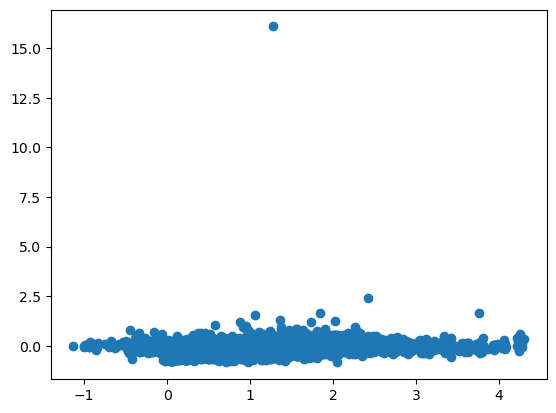

In [49]:
plt.scatter(x,y)

Text(0, 0.5, 'Monthly Returns')

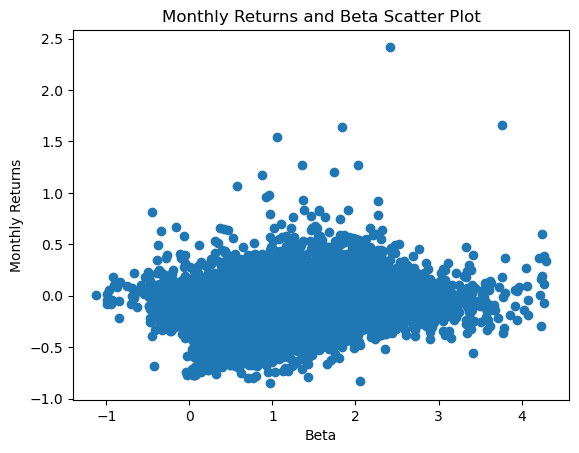

In [54]:
#remove outlier
outlier_idx = np.argmax(y)
x_1 = x[:outlier_idx] + x[outlier_idx+1:]
y_1 = y[:outlier_idx] + y[outlier_idx+1:]
plt.scatter(x_1,y_1)
plt.title("Monthly Returns and Beta Scatter Plot")
plt.xlabel("Beta")
plt.ylabel("Monthly Returns")

In [57]:
res = sm.OLS(np.array(y_1).reshape(-1),sm.add_constant(np.array(x_1).reshape((-1,1)))).fit()

In [59]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                 1.053e+04
Date:                Fri, 12 May 2023   Prob (F-statistic):               0.00
Time:                        13:43:02   Log-Likelihood:                 57152.
No. Observations:              106411   AIC:                        -1.143e+05
Df Residuals:                  106409   BIC:                        -1.143e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2094      0.001   -213.248      0.000      -0.211      -0.208
x1             0.0949      0.001    102.633      0.000       0.093       0.097
==============================================================================
Omnibus:                     6239.484   Durbin-Watson:                   0.771
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27028.011
Skew:                          -0.066   Prob(JB):                         0.00
Kurtosis:                       5.465   Cond. No.                         4.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
np.corrcoef(np.column_stack((np.array(x_1),np.array(y_1))),rowvar=False)

array([[1.        , 0.30012311],
       [0.30012311, 1.        ]])

Correlation coefficient of 0.3 indicates some weak-moderate positive linear association between beta and monthly returns

# End

# Plot beta and returns for yearly data

For each year, to get the current beta of an asset up to that year, regress prior years' returns for the asset on prior years' returns for the market (include an intercept term). Obviously, the return we want to associate with that beta is the return of the asset in that year.

In [61]:
yearly_beta_dict = {}

for yr in range(2012,2023):
    yearly_beta_dict[yr] = {}
    market_returns = []
    start_yr = 2010
    for yr_iter in range(start_yr,yr):
        market_returns.append(yearly_rets[str(yr_iter)]['Market'])
    market_returns = np.array(market_returns).reshape((-1,1))
    exog = sm.add_constant(market_returns)
    for s in symbols:
        asset_returns = []
        for yr_iter in range(start_yr,yr):
            asset_returns.append(yearly_rets[str(yr_iter)][s])
        asset_returns = np.array(asset_returns).reshape(-1)
        res = sm.OLS(asset_returns,exog).fit()
        beta = res.params[1]
        yearly_beta_dict[yr][s] = beta    

In [62]:
x = [] #beta of equities up to a certain year, y
y = [] #yearly returns for that same year, y

for s in symbols:
    for yr in range(2012,2023):
        x.append(yearly_beta_dict[yr][s])
        y.append(yearly_rets[str(yr)][s])

In [63]:
len(x) == len(y)

True

Text(0, 0.5, 'Annual Returns')

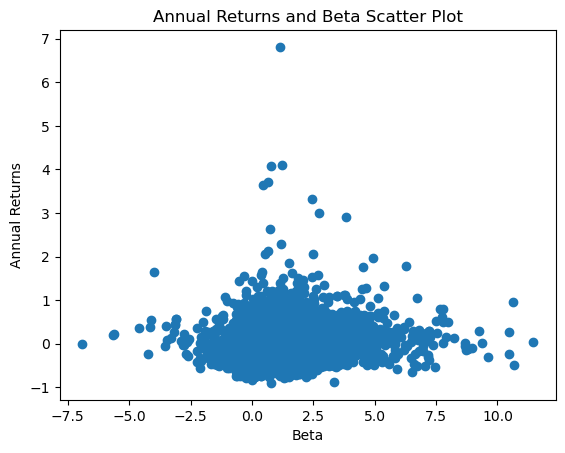

In [64]:
plt.scatter(x,y)
plt.title("Annual Returns and Beta Scatter Plot")
plt.xlabel("Beta")
plt.ylabel("Annual Returns")

In [65]:
res = sm.OLS(np.array(y).reshape(-1),sm.add_constant(np.array(x).reshape((-1,1)))).fit()

In [66]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     126.0
Date:                Fri, 12 May 2023   Prob (F-statistic):           5.12e-29
Time:                        14:09:50   Log-Likelihood:                -2692.0
No. Observations:                7909   AIC:                             5388.
Df Residuals:                    7907   BIC:                             5402.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0421      0.005     -8.216      0.000      -0.052      -0.032
x1             0.0338      0.003     11.225      0.000       0.028       0.040
==============================================================================
Omnibus:                     5741.506   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           379335.750
Skew:                           2.854   Prob(JB):                         0.00
Kurtosis:                      36.444   Cond. No.                         2.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
np.corrcoef(np.column_stack((np.array(x),np.array(y))),rowvar=False)

array([[1.        , 0.12523645],
       [0.12523645, 1.        ]])

Correlation coefficientt of 0.125 implies weak positive linear association between beta and annual returns